## 데이터 준비하기

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='NanumGothic'

import json
import pandas as pd
import numpy as np
import FinanceDataReader as fdr


stock2code = json.load(open('data/stock2code.json','r'))
universe = ['NAVER','삼성SDI','삼성전자','SK하이닉스','LG화학','한국전력','현대차','셀트리온','기아','POSCO','현대모비스','대한항공','LG전자']

df = pd.DataFrame()
for stock in universe:
    df = pd.concat([df, fdr.DataReader(stock2code[stock]).Close], axis=1)
    
df.columns = universe
df = np.log(df) - np.log(df.shift(1))
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)
df

## MDD

In [ ]:
def drawdown(rt):
    rt = (1+rt).cumprod()
    past = rt.cummax()
    dd = (rt - past) / past
    return dd

In [ ]:
df.apply(drawdown)[['NAVER','삼성SDI']].plot(figsize=(14,5))
plt.show()

## Sharpe Ratio

In [ ]:
def annualize_rt(rt, p):
    return (1 + rt).prod() ** (p/len(rt)) - 1
    
def annualize_vol(rt, p):
    """ 
    수익률에 대한 표준편차
    p : 252(daily), 12(month), 4(quarter)
    """
    return rt.std() * np.sqrt(p)

def sharpe_ratio(rt, rf, p):
    excess_rt = annualize_rt(rt, p) - rf
    annualized_vol = annualize_vol(rt, p)
    return excess_rt / annualized_vol
    

In [ ]:
tmp = sharpe_ratio(df.loc['2016':'2020'], 0.02, 252)   #risk_free rate : 0.02
tmp.sort_values(ascending=False).plot(kind='bar', figsize=(14,5))
plt.show()

In [ ]:
expected_rt = annualize_rt(df.loc['2016':'2020'], 252)
expected_rt.sort_values(ascending=False).plot(kind='bar', figsize=(14,5))
plt.show()

In [ ]:
vol = annualize_vol(df.loc['2016':'2020'], 252)
vol.sort_values(ascending=False).plot(kind='bar', figsize=(14,5))
plt.show()

## 효율적경계선

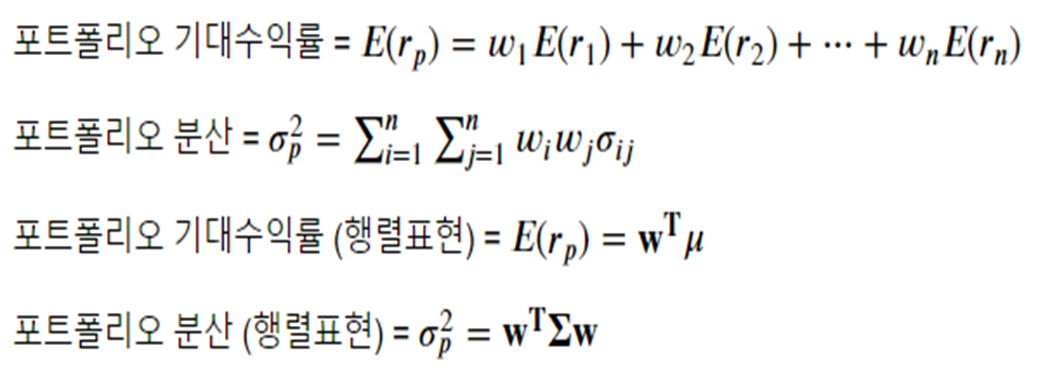

In [ ]:
def portfolio_rt(w, rt):
    return w.T @ rt

def portfolio_vol(w, cov):
    return np.sqrt( w.T @ cov @ w)

In [ ]:
cov = df.loc['2016':'2020'].cov()
cov

## 2개의 종목으로 구성한 포트폴리오

In [ ]:
selected_stocks = ['NAVER','POSCO']
n_points = 100
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
weights

In [ ]:
#포트폴리오 기대수익률, 포트폴리오 변동성 구하기
p_returns = [portfolio_rt(weight, expected_rt.loc[selected_stocks]) for weight in weights]
p_vols = [portfolio_vol(weight, cov.loc[selected_stocks,selected_stocks]) for weight in weights]

In [ ]:
# 투자기회선 시각화
frontier = pd.DataFrame({'p_Return':p_returns, 'p_Volatility':p_vols})
frontier.plot(kind='scatter', x='p_Volatility',y='p_Return')
plt.show()

### pyportfolioopt

- https://pyportfolioopt.readthedocs.io/en/latest/

In [ ]:
!pip install PyPortfolioOpt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
ef = EfficientFrontier(expected_rt.loc[selected_stocks], cov.loc[selected_stocks, selected_stocks], weight_bounds=(0, 1))

# 샤프비율 최대화
weights_max_sharpe = ef.max_sharpe()
weights_max_sharpe = ef.clean_weights()
print("샤프비율 최대화", weights_max_sharpe)

In [ ]:
opt_r = portfolio_rt(np.array(list(weights_max_sharpe.values())), expected_rt.loc[selected_stocks])
opt_v = portfolio_vol(np.array(list(weights_max_sharpe.values())), cov.loc[selected_stocks,selected_stocks])

In [ ]:
frontier = pd.DataFrame({'p_Return':p_returns, 'p_Volatility':p_vols})
frontier.plot(kind='scatter', x='p_Volatility',y='p_Return')
plt.scatter(opt_v, opt_r, s=200, c='red')
plt.show()

## N개자산

In [ ]:
universe = ['NAVER','삼성SDI','삼성전자','SK하이닉스','LG화학','한국전력','현대차','셀트리온','기아','POSCO','현대모비스','대한항공','LG전자']

df = pd.DataFrame()
for stock in universe:
    df = pd.concat([df, fdr.DataReader(stock2code[stock]).Close], axis=1)
    
df.columns = universe
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)
df

In [ ]:
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
mu = expected_returns.mean_historical_return(df)
s = risk_models.sample_cov(df)

In [ ]:
ef = EfficientFrontier(mu, s, weight_bounds=(0,1))
weights = ef.min_volatility()  #max_sharpe
weights = ef.clean_weights()
weights

In [ ]:
ef.portfolio_performance(verbose=True)